# Ejercicio 1

In [2]:
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl

In [3]:
# Antecedentes
universo_reparaciones = np.arange(2, 21, 1)
universo_monto = np.arange(759, 35251, 1)
universo_calificacion = np.arange(15, 86, .1)

# Consecuentes
universo_prima = np.arange(1700, 6201, 1)

In [4]:
reparaciones = ctrl.Antecedent(universo_reparaciones, "reparaciones")
monto = ctrl.Antecedent(universo_monto, "monto")
calificacion = ctrl.Antecedent(universo_calificacion, "calificacion")
prima = ctrl.Consequent(universo_prima, "prima")

#### Fuzzyficar

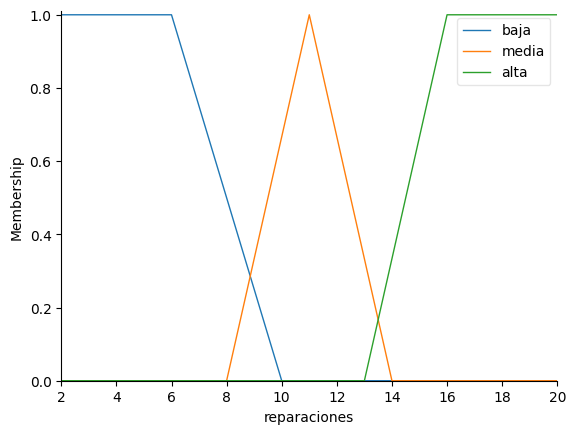

In [5]:
reparaciones["baja"] = fuzz.trapmf(universo_reparaciones, [2, 2, 6, 10])
reparaciones["media"] = fuzz.trimf(universo_reparaciones, [8, 11, 14])
reparaciones["alta"] = fuzz.trapmf(universo_reparaciones, [13, 16, 20, 20])
reparaciones.view()

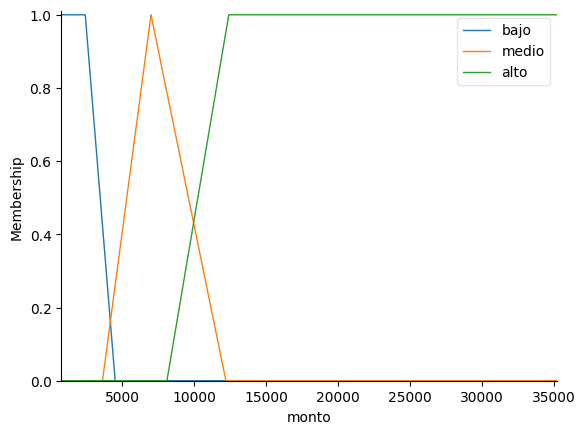

In [6]:
monto["bajo"] = fuzz.trapmf(universo_monto, [0, 750, 2427, 4500])
monto["medio"] = fuzz.trimf(universo_monto, [3625, 7000, 12200])
monto["alto"] = fuzz.trapmf(universo_monto, [8105, 12400, 35250, 35250])
monto.view()

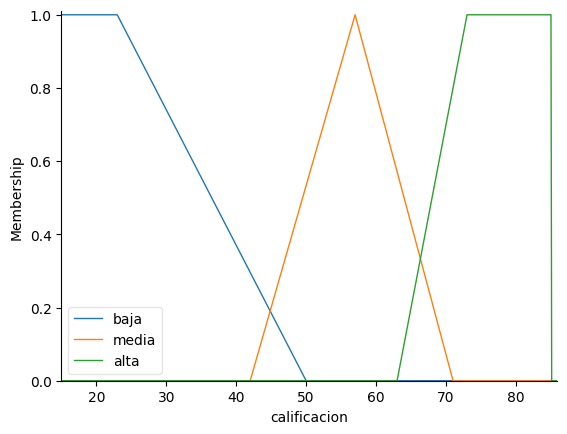

In [7]:
calificacion["baja"] = fuzz.trapmf(universo_calificacion, [15, 15, 23, 50])
calificacion["media"] = fuzz.trimf(universo_calificacion, [42, 57, 71])
calificacion["alta"] = fuzz.trapmf(universo_calificacion, [63, 73, 85, 85])
calificacion.view()

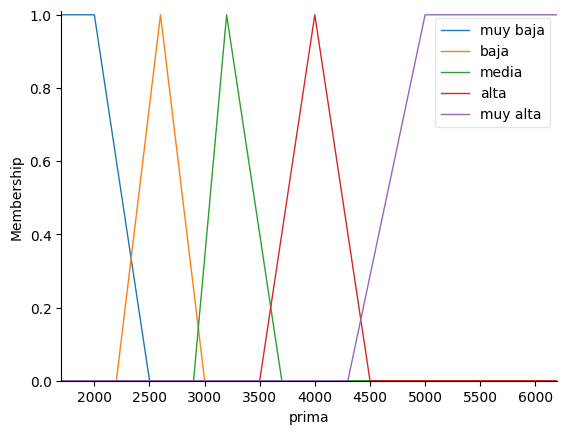

In [8]:
prima["muy baja"] = fuzz.trapmf(universo_prima, [1700, 1700, 2000, 2500])
prima["baja"] = fuzz.trimf(universo_prima, [2200, 2600,  3000])
prima["media"] = fuzz.trimf(universo_prima, [2900, 3200, 3700])
prima["alta"] = fuzz.trimf(universo_prima, [3500, 4000, 4500])
prima["muy alta"] = fuzz.trapmf(universo_prima, [4300, 5000, 6200, 6200])
prima.view()

#### Reglas

In [9]:
regla_muy_baja = ctrl.Rule(reparaciones['alta'] & monto['alto'] & calificacion['baja'], prima['muy baja'])
regla_baja = ctrl.Rule(
    (reparaciones['alta'] | monto['medio']) & calificacion['baja'] |
    (reparaciones['media'] | monto['alto']) & calificacion['baja'] |
    (reparaciones['alta'] | monto['alto']) & calificacion['media']
    , prima['baja']
    )
regla_media = ctrl.Rule(
    (reparaciones['media'] | monto['medio']) & calificacion['baja'] |
    (reparaciones['media'] | monto['alto']) & calificacion['media'] |
    (reparaciones['alta'] | monto['medio']) & calificacion['media'] |
    (reparaciones['alta'] | monto['alto']) & calificacion['alta'] |
    (reparaciones['baja'] | monto['alto']) & calificacion['baja'] |
    (reparaciones['alta'] | monto['bajo']) & calificacion['baja']
    , prima['media']
    )
regla_alta = ctrl.Rule(
    (reparaciones['media'] | monto['medio']) & calificacion['media'] |
    (reparaciones['media'] | monto['medio']) & calificacion['alta'] |
    (reparaciones['media'] | monto['bajo']) & calificacion['media'] |
    (reparaciones['baja'] | monto['medio']) & calificacion['media'] |
    (reparaciones['baja'] | monto['bajo']) & calificacion['media']
    , prima['media']
    )
regla_muy_alta = ctrl.Rule(reparaciones['baja'] & monto['bajo'] & calificacion['alta'], prima['muy baja'])

In [10]:
control_primas = ctrl.ControlSystem([regla_muy_alta, regla_alta, regla_media, regla_baja, regla_muy_baja])

#### Simulación

In [11]:
valor_prima = ctrl.ControlSystemSimulation(control_primas)
valor_prima.input["reparaciones"] = 9
valor_prima.input["monto"] = 3400
valor_prima.input["calificacion"] = 65
valor_prima.compute()

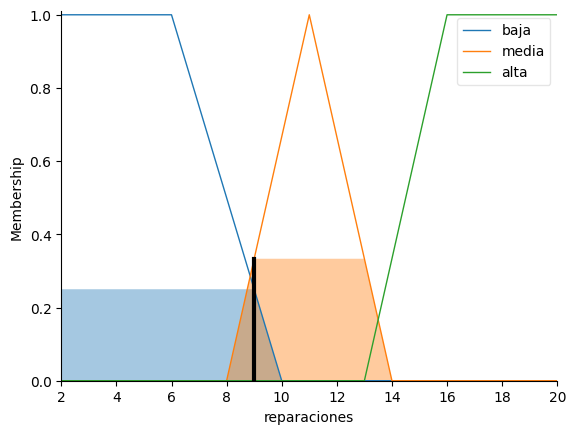

In [12]:
reparaciones.view(sim = valor_prima)

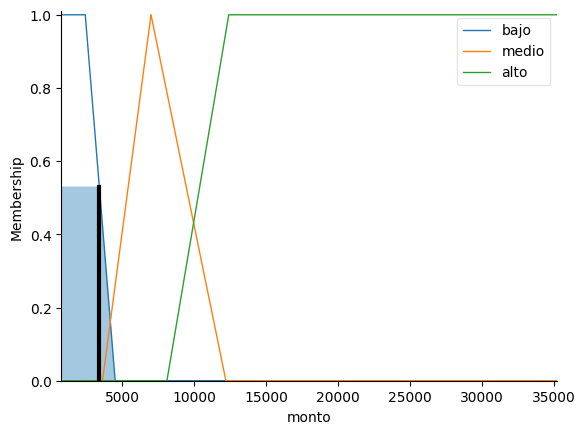

In [13]:
monto.view(sim = valor_prima)

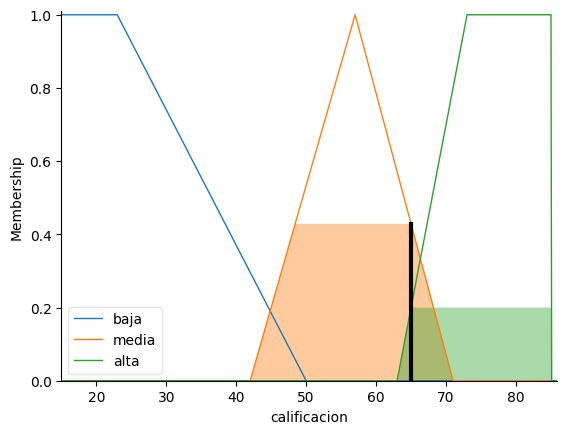

In [14]:
calificacion.view(sim = valor_prima)

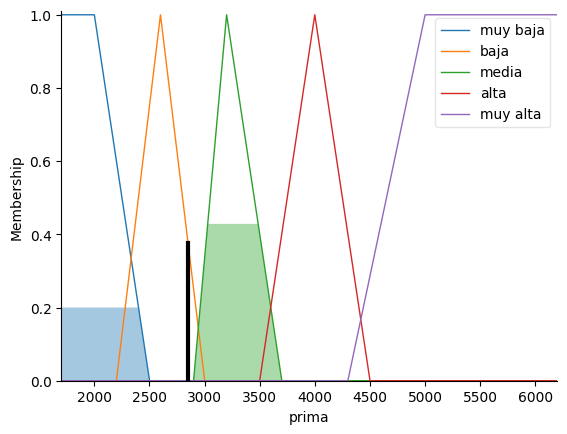

In [15]:
prima.view(sim = valor_prima)

In [16]:
round(valor_prima.output["prima"], 3)

2849.547

# Ejercicio 2

### 2.a

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import random as rnd
import yfinance as yf
from deap import algorithms, base, creator, tools

import warnings
warnings.filterwarnings("ignore")

In [19]:
data = np.zeros((5, 4))

# Asignar valores a las filas y columnas
data[0, 0] = 1200
data[0, 1] = 15000
data[0, 2] = 1500
data[0, 3] = 400

data[1, 0] = 2300
data[1, 1] = 18000
data[1, 2] = 2500
data[1, 3] = 600

data[2, 0] = 700
data[2, 1] = 17000
data[2, 2] = 800
data[2, 3] = 1200

data[3, 0] = 1800
data[3, 1] = 12000
data[3, 2] = 1600
data[3, 3] = 500

data[4, 0] = 2000
data[4, 1] = 16000
data[4, 2] = 300
data[4, 3] = 300

In [20]:
df = pd.DataFrame(data, columns=["cantidad_ventas", "precio_unitario", "distancia", "costo"])

# Agregar los nombres de las tiendas como índice
df.index = ["tienda{}".format(i+1) for i in range(5)]

# Mostrar el dataframe
df

,cantidad_ventas,precio_unitario,distancia,costo
tienda1,1200.0,15000.0,1500.0,400.0
tienda2,2300.0,18000.0,2500.0,600.0
tienda3,700.0,17000.0,800.0,1200.0
tienda4,1800.0,12000.0,1600.0,500.0
tienda5,2000.0,16000.0,300.0,300.0


In [21]:
def adaptabilidad(individuo):
  limite = 4000
  utilidad = 0
  distancia = np.dot(individuo, df["distancia"])
  if distancia <= limite:
    for i, bit in enumerate(individuo):
      if bit:
        j = i+1
        row = f"tienda{j}"
        utilidad += ((df.loc[row, "precio_unitario"] * df.loc[row, "cantidad_ventas"]) - (df.loc[row, "distancia"] * df.loc[row, "costo"]))
  else:
    utilidad = 0

  return utilidad,

In [22]:
# Contenedor
toolbox = base.Toolbox()

# Declarar clase función de adaptabilidad
creator.create("FitnessMax", base.Fitness, weights = (1.0,))

# Crear la clase individuo
creator.create("Individual", list, fitness = creator.FitnessMax)

In [23]:
# Construir cromosomas bit
toolbox.register("attribute", rnd.randint, 0, 1)

# Construir el individuo
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n = 5)

#Crear población
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [24]:
individuo = toolbox.individual()
print(individuo)

[1, 1, 0, 1, 1]


In [25]:
poblacion = toolbox.population(n = 100)
print(poblacion)

[[1, 1, 1, 0, 1], [1, 1, 1, 1, 0], [1, 1, 0, 0, 1], [0, 0, 0, 0, 0], [0, 1, 1, 0, 1], [0, 1, 0, 0, 1], [1, 1, 0, 1, 1], [1, 0, 0, 0, 0], [1, 0, 1, 0, 1], [1, 1, 1, 1, 1], [1, 0, 1, 0, 1], [0, 0, 0, 1, 0], [1, 0, 1, 0, 1], [0, 1, 1, 0, 0], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0], [0, 0, 1, 1, 0], [1, 0, 0, 0, 1], [1, 0, 1, 1, 0], [1, 1, 1, 1, 1], [1, 1, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [1, 1, 0, 1, 0], [1, 0, 0, 1, 1], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 1, 0], [0, 0, 1, 0, 1], [1, 0, 0, 0, 1], [0, 1, 1, 0, 0], [1, 1, 1, 1, 0], [0, 1, 1, 0, 1], [0, 1, 1, 1, 0], [0, 1, 1, 1, 0], [1, 0, 1, 0, 0], [1, 0, 1, 0, 1], [1, 0, 0, 1, 0], [1, 1, 1, 0, 1], [0, 1, 1, 1, 0], [1, 0, 0, 1, 1], [0, 0, 1, 1, 1], [1, 1, 1, 1, 0], [1, 1, 1, 1, 1], [1, 1, 0, 0, 0], [0, 1, 1, 0, 0], [0, 1, 0, 0, 0], [1, 0, 1, 0, 1], [0, 0, 0, 1, 1], [1, 0, 0, 1, 1], [1, 1, 0, 0, 1], [0, 1, 0, 0, 1], [1, 0, 1, 0, 0], [0, 0, 0, 1, 1], [1, 0, 1, 1, 0], [0, 1, 0, 0, 

In [26]:
# Definir las funciones genéticas
# Selección
toolbox.register("select", tools.selTournament, tournsize = 3)

# Cruce
toolbox.register("mate", tools.cxOnePoint)

# Mutación
toolbox.register("mutate", tools.mutFlipBit, indpb = 0.1)

# Evaluación
toolbox.register("evaluate", adaptabilidad)

In [27]:
# Configuración de estadísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("Promedio", np.mean)
stats.register("Desviación Estandar", np.std)
stats.register("Mínimo", np.min)
stats.register("Máximo", np.max)

In [28]:
population = toolbox.population(n = 100)
population, logbook = algorithms.eaSimple(population, toolbox, cxpb = 1, mutpb = 0.1, ngen = 50, verbose = True, stats = stats)
print(logbook)

gen	nevals	Promedio   	Desviación Estandar	Mínimo	Máximo   
0  	100   	2.76515e+07	2.67722e+07        	0     	8.275e+07
1  	100   	3.16007e+07	2.66315e+07        	0     	8.275e+07
2  	100   	3.8388e+07 	2.88314e+07        	0     	8.275e+07
3  	100   	4.19758e+07	2.91095e+07        	0     	8.275e+07
4  	100   	5.74456e+07	2.67625e+07        	0     	8.275e+07
5  	100   	7.38674e+07	1.86583e+07        	0     	8.275e+07
6  	100   	7.88313e+07	1.55652e+07        	0     	8.275e+07
7  	100   	7.83711e+07	1.62329e+07        	0     	8.275e+07
8  	100   	8.13846e+07	8.89873e+06        	0     	8.275e+07
9  	100   	8.15235e+07	9.10447e+06        	0     	8.275e+07
10 	100   	8.05866e+07	1.22224e+07        	0     	8.275e+07
11 	100   	7.74954e+07	1.95513e+07        	0     	8.275e+07
12 	100   	8.07759e+07	1.19682e+07        	0     	8.275e+07
13 	100   	7.94196e+07	1.35096e+07        	0     	8.275e+07
14 	100   	8.19225e+07	8.23352e+06        	0     	8.275e+07
15 	100   	7.9041e+07 	1.66152e+07      

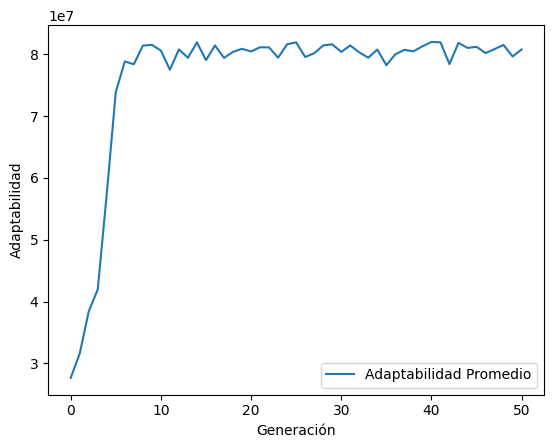

In [29]:
gen = logbook.select("gen")
avgs = logbook.select("Promedio")
plt.plot(gen, avgs, label = "Adaptabilidad Promedio")
plt.legend()
plt.xlabel("Generación")
plt.ylabel("Adaptabilidad")
plt.show()

In [30]:
tools.selBest(population, 1)[0]

[0, 1, 1, 0, 1]

### 2.b

In [31]:
def adaptabilidad_evolutiva(individuo):
  utilidad = 0
  for i, valor in enumerate(individuo):
    j = i+1
    row = f"tienda{j}"
    utilidad += ((df.loc[row, "precio_unitario"] * df.loc[row, "cantidad_ventas"]) - (valor * df.loc[row, "costo"]))

  return utilidad,

In [32]:
# Contenedor
toolbox = base.Toolbox()

# Declarar clase función de adaptabilidad
creator.create("FitnessMax", base.Fitness, weights = (1.0,))

# Crear la clase individuo
creator.create("Individual2", list, fitness = creator.FitnessMax)

In [33]:
# Construir cromosomas bit
toolbox.register("attribute", rnd.uniform, 300, 1500)

# Construir el individuo
toolbox.register("individual2", tools.initRepeat, creator.Individual2, toolbox.attribute, n = 5)

#Crear población
toolbox.register("population2", tools.initRepeat, list, toolbox.individual2, n = 50)

In [34]:
individuo = toolbox.individual2()
print(individuo)

[742.4722212787426, 319.6915354335695, 964.3612262850279, 560.7938874677693, 1302.555166710752]


In [35]:
poblacion = toolbox.population2()
print(poblacion)

[[934.6662897161973, 957.9020053453976, 790.7005948911424, 1144.0715255684286, 1459.6123238918199], [963.5435353333819, 952.301136114322, 980.4799525400107, 625.6013640471954, 1118.8997188174526], [1033.5013043062581, 495.76690986845415, 1414.9972001407948, 927.5838186287824, 1354.4818427865994], [581.3638598692627, 1078.2504305612888, 1164.3200729258015, 446.727605796949, 1118.64817874213], [305.35520283662913, 523.0651654426331, 608.5872926537645, 915.3370519879684, 370.05848255530907], [597.7587602268636, 528.53825083874, 1361.0424784223035, 980.5366677059579, 765.1105279635728], [520.8464336999643, 725.550242730702, 1119.8995580376304, 988.202335821953, 898.9049645700368], [975.0053912553599, 1401.2793276888153, 1474.77917903727, 591.4454347704227, 948.6587403217019], [307.2726200049648, 737.5720481501316, 1194.726235635294, 878.3551474296822, 1358.977926009076], [1488.2447872030298, 1282.2406240479054, 1090.3660634103067, 455.1649689013321, 1268.3554679323738], [370.0005721214397,

In [36]:
# Definir las funciones genéticas
# Selección
toolbox.register("select", tools.selTournament, tournsize = 3)

# Cruce
toolbox.register("mate", tools.cxUniform, indpb=0.5)

# Mutación
toolbox.register("mutate", tools.mutUniformInt, low=500, up=1000, indpb = 0.1)

# Evaluación
toolbox.register("evaluate", adaptabilidad_evolutiva)

In [37]:
# Configuración de estadísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("Promedio", np.mean)
stats.register("Desviación Estandar", np.std)
stats.register("Mínimo", np.min)
stats.register("Máximo", np.max)

In [38]:
population = toolbox.population2()
population, logbook = algorithms.eaSimple(population, toolbox, cxpb = 0.5, mutpb = 0.1, ngen = 20, verbose = True, stats = stats)
print(logbook)

gen	nevals	Promedio   	Desviación Estandar	Mínimo     	Máximo     
0  	50    	1.22067e+08	543091             	1.20919e+08	1.23235e+08
1  	28    	1.22542e+08	406856             	1.21559e+08	1.23262e+08
2  	21    	1.22877e+08	288214             	1.22081e+08	1.23275e+08
3  	37    	1.23126e+08	236522             	1.22354e+08	1.2373e+08 
4  	32    	1.23339e+08	194061             	1.22865e+08	1.2373e+08 
5  	24    	1.23489e+08	128380             	1.23271e+08	1.2373e+08 
6  	26    	1.23575e+08	114776             	1.23331e+08	1.23796e+08
7  	31    	1.23655e+08	103705             	1.23385e+08	1.23796e+08
8  	28    	1.23754e+08	51476              	1.23596e+08	1.23796e+08
9  	26    	1.23774e+08	96397.5            	1.23107e+08	1.23796e+08
10 	31    	1.23779e+08	100407             	1.23084e+08	1.23796e+08
11 	32    	1.23777e+08	89475.4            	1.2322e+08 	1.23796e+08
12 	30    	1.23779e+08	94429.4            	1.23138e+08	1.23796e+08
13 	39    	1.23778e+08	92031.3            	1.23223e+08	1.23796

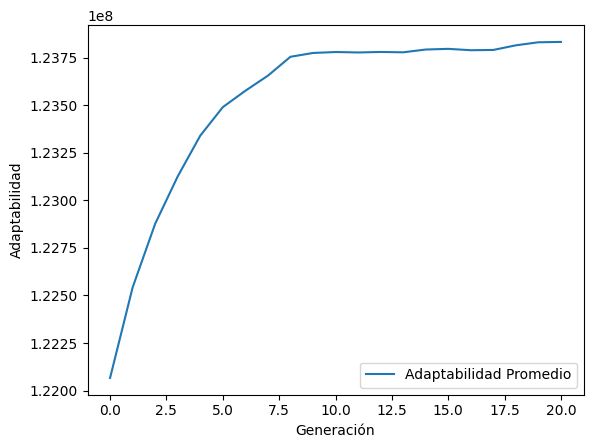

In [39]:
gen = logbook.select("gen")
avgs = logbook.select("Promedio")
plt.plot(gen, avgs, label = "Adaptabilidad Promedio")
plt.legend()
plt.xlabel("Generación")
plt.ylabel("Adaptabilidad")
plt.show()

In [40]:
tools.selBest(population, 1)[0]

[301.3585326348441,
 325.77423447102996,
 338.1886910580966,
 300.73922077542517,
 579]